# MNIST dataset
![](https://i.imgur.com/mdLvmn4.png)

-  [Introduction](#intro)

## Introduction <a id = "intro"></a>

The MINST dataset files used in  this tutorial can be downloaded from [The MINST Database](http://yann.lecun.com/exdb/mnist/)

The MNIST dataset was constructed from two datasets of the US __National Institute of Standards and Technology__ (NIST). The training set consists of handwritten digits from 250 different people, 50 percent high school students, and 50 percent employees from the Census Bureau. Note that the test set contains handwritten digits from different people following the same split.

The MNIST dataset contains 60,000 training images and 10,000 test images.

In this notebook we will look at how to read the MNIST dataset efficiently into memory.

## File Format of the MNIST Database
The data is stored in a very simple file format designed for storing vectors and multidimensional matrices.

All the integers in the files are stored in the MSB first (high endian) format used by most non-Intel processors. Users of Intel processors and other low-endian machines must flip the bytes of the header.

There are 4 files:

- train-images-idx3-ubyte: training set images
- train-labels-idx1-ubyte: training set labels
- t10k-images-idx3-ubyte:  test set images
- t10k-labels-idx1-ubyte:  test set labels

The training set contains 60000 examples and labels, and the test set contains 10000 examples and labels.

## The IDX File Format
the IDX file format is a simple format for vectors and multidimensional matrices of various numerical types.

The basic format is

- magic number
- size in dimension 0
- size in dimension 1
- size in dimension 2
- .....
- size in dimension N
- data

The magic number is an integer (MSB first). The first 2 bytes are always 0.

The third byte codes the type of the data:
- 0x08: unsigned byte
- 0x09: signed byte
- 0x0B: short (2 bytes)
- 0x0C: int (4 bytes)
- 0x0D: float (4 bytes)
- 0x0E: double (8 bytes)

The 4-th byte codes the number of dimensions of the vector/matrix: 1 for vectors, 2 for matrices....

The sizes in each dimension are 4-byte integers (MSB first, high endian, like in most non-Intel processors).

The data is stored like in a C array, i.e. the index in the last dimension changes the fastest. 


## Prepare The Data
In order to use the MNIST dataset we need to organise the data into a usable format. The zipped folders contains images stored as _.idx_ files.

### Decompress .gz file
First we must decompress the files. This can be done easily by using Pythons __[gzip](https://docs.python.org/3/library/gzip.html)__ module. This module provides a simple interface for dealing with compressed files with functions such as _open()_,_compress()_, and _decompress()_.

In [1]:
# https://docs.python.org/3/library/gzip.html
# Must import gzip to allow pyhton to read  and uncompress zip files
import gzip

# Unzip and open file for reading
with gzip.open('data/t10k-images-idx3-ubyte.gz', 'rb') as f:
    file_content = f.read()

### Read Bytes
Reading bytes from the file is simple, the first 16 bytes of _t10k-images-idx3-ubyte.gz_ allow us to retrieve information about the file.

In [2]:
# Read first 4 bytes of file
print("Data is of type :",type(file_content[0:4]))

# Get byte codes and integer values
print("Bytes contained in file_content[0:4]   :",file_content[0:4],"\tAs Integer :",int.from_bytes(file_content[0:4],byteorder='big'))
print("Bytes contained in file_content[4:8]   :",file_content[4:8],"\tAs Integer :",int.from_bytes(file_content[4:8],byteorder='big'))
print("Bytes contained in file_content[8:12]  :",file_content[8:12],"\tAs Integer :",int.from_bytes(file_content[8:12],byteorder='big'))
print("Bytes contained in file_content[12:16] :",file_content[12:16],"\tAs Integer :",int.from_bytes(file_content[12:16],byteorder='big'))

Data is of type : <class 'bytes'>
Bytes contained in file_content[0:4]   : b'\x00\x00\x08\x03' 	As Integer : 2051
Bytes contained in file_content[4:8]   : b"\x00\x00'\x10" 	As Integer : 10000
Bytes contained in file_content[8:12]  : b'\x00\x00\x00\x1c' 	As Integer : 28
Bytes contained in file_content[12:16] : b'\x00\x00\x00\x1c' 	As Integer : 28


From the above data we can gather the following about the file:
    - Type of data is unsigned byte (x08)
    - Number of dimensions is 3(x03)
    - Number of images is 10000
    - Number of rows is 28
    - Number of columns is 28

### Read Image Data
Each vector in the matrix consists of 784 pixels derived from the original 28x28 pixel images. We can load each 784  set into a 28X28 numpy array as an unassigned 8 bit integer.

In [3]:
# Import the Python image library
import PIL

# Import numpy as np
import numpy as np

# convert data to 28x28 array
# '~' tilde symbol inverts bit ie. 1 to 0 , 0 to 1
image = ~np.array(list(file_content[16:800])).reshape(28,28).astype(np.uint8)

### Display Image

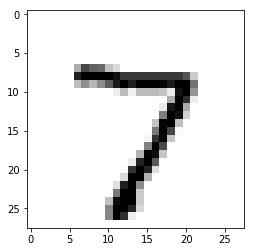

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')

We Can also visualize an image by printing out its rgb values

In [5]:
# Visualise image by printing out its values(. for 0 and # for rgb)
for x in image:
    print()
    for y in x:
        if(y != 255):
            print("#", end="")
        else:
            print(".", end="")


............................
............................
............................
............................
............................
............................
............................
......######................
......################......
......################......
...........###########......
..................####......
.................####.......
.................####.......
................####........
................####........
...............####.........
...............###..........
..............####..........
.............####...........
............#####...........
............####............
...........#####............
...........####.............
..........#####.............
..........#####.............
..........####..............
............................

### Read Label Data
The label files are formatted similar to the image files. The first 4 bytes give us information about the file 

In [6]:
# read labels from file
with gzip.open('data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    labels = f.read()

print("Magic Number    : ",labels[4:8])  
print("Number of items : ",int.from_bytes(labels[4:8], byteorder="big"))  

# Display Label as bytes    
print("Display Label as bytes   : ",labels[8:9])
# Desplay  Label as int
print("Display Label as Integer : ",int.from_bytes(labels[8:9], byteorder="big"))

Magic Number    :  b"\x00\x00'\x10"
Number of items :  10000
Display Label as bytes   :  b'\x07'
Display Label as Integer :  7


## Load all Images and Labels
To be able to be able to train a machine learning model we must load all data into memory. In this section we will create and load data into four data sets:
- train_image : Images used to train the model
- train_label : Labels used to train the model
- test_image  : Images used to test the model
- test_label  : Labels used to test the model

### Load Test Sets

In [7]:
# import time it to measure performance
import timeit

# Loading test sets
test_image = []
test_label= []
testListArray=[]

imageSize = 784

# i,j act as offsets to offest idx format 
i=16
j=8

# Start timer
start_time_test = timeit.default_timer()

# Iterate through file
while (i < len(file_content)): 
    # Add image to array
    test_image.append(~np.array(list(file_content[i:i+imageSize])).reshape(28,28).astype(np.uint8))
    # Add label to array
    test_label.append(int.from_bytes(labels[j:j+1], byteorder="big"))
    
    i += imageSize
    j = j+1

# Stop Timer
timeTakenTest = timeit.default_timer() - start_time_test

# Add arrays to test array   
testListArray.append(test_image)
testListArray.append(test_label)

print("Length test_image:",len(test_image)," Length test_label:",len(test_label))

# test for correct values
i = 0
for i in range(2):
    
    for x in testListArray[0][i]:
        print()
        for y in x:
            if(y != 255):
                print("#", end="")
            else:
                print(".", end="")
   
    print("\nCorresponding Label :",testListArray[1][i])

Length test_image: 10000  Length test_label: 10000

............................
............................
............................
............................
............................
............................
............................
......######................
......################......
......################......
...........###########......
..................####......
.................####.......
.................####.......
................####........
................####........
...............####.........
...............###..........
..............####..........
.............####...........
............#####...........
............####............
...........#####............
...........####.............
..........#####.............
..........#####.............
..........####..............
............................
Corresponding Label : 7

............................
............................
............................
..........#######.......

### Load Training sets

In [8]:
# Unzip and open training image and label file for reading
with gzip.open('data/train-images-idx3-ubyte.gz', 'rb') as f:
    train_images_content = f.read()
    
with gzip.open('data/train-labels-idx1-ubyte.gz', 'rb') as f:
    train_labels_content = f.read()   
    
train_image = []
train_label = []
imageSize = 784
trainImageSize=len(train_images_content)

# i,j act as offsets to offest idx format 
i=16
j=8

# Start timer
start_time_train = timeit.default_timer()

#Performance tweeks
appendI = train_image.append
appendL = train_label.append

# Iterate through file
while (i < trainImageSize): 
    # Add image to array
    appendI(~np.array(list(train_images_content[i:i+imageSize])).reshape(28,28).astype(np.uint8))
    # Add label to array
    appendL(int.from_bytes(train_labels_content[j:j+1], byteorder="big"))
    
    i += imageSize
    j += 1

# Stop Timer
timeTakenTrain = timeit.default_timer() - start_time_train

# test for correct values
i = 0
for i in range(2):
    
    for x in train_image[i]:
        print()
        for y in x:
            if(y != 255):
                print("#", end="")
            else:
                print(".", end="")
   
    print("\nCorresponding Label :",train_label[i])  


............................
............................
............................
............................
............................
............############....
........################....
.......################.....
.......###########..........
........#######.##..........
.........#####..............
...........####.............
...........####.............
............######..........
.............######.........
..............######........
...............#####........
.................####.......
..............#######.......
............########........
..........#########.........
........##########..........
......##########............
....##########..............
....########................
............................
............................
............................
Corresponding Label : 5

............................
............................
............................
............................
...............#####........
..............###

# Performance Statistics

In [18]:
print("Load test data Executed in ",timeTakenTest)
print("Load train data Executed in ",timeTakenTrain)

Load test data Executed in  0.9783442068669936
Load train dataExecuted in  5.246099276616858


### Save Images to Memory
The openCv library makes it easy to save images into memory. We save the images in the format "trainImg" + the index of the image along with the label corresponding to the value of the image. As we have already formatted the images into an array of 28x 28 numpy array we just need to call on the _imwrite()_ function. We only save the first 3 images here as its only an example.

In [17]:
## Os allows path name manipulation
import os
# openCv allows us to save show,read and write image
import cv2 

path = 'saved_images/' # directory to save images
for x in range(3):
    cv2.imwrite(os.path.join(path,'trainImg'+ str(x) + '_'+str(train_label[x]) +  '.png'),train_image[x])


## References

- [Info on MNIST dataset](http://yann.lecun.com/exdb/mnist/)
- [gzip](https://docs.python.org/3/library/gzip.html)
- [Deep Learing](http://deeplearning.net/tutorial/gettingstarted.html)
- [OpenCv](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html)